# Point source response generation example

This example handles the point source response.

Each tra file or orientation file stores the pointings of the x and z axes (or additional y axis) of the spacecraft (SC) in the galactic frame (longitude and latitude). To get the pointings you can run the classic COSIpy for spetral analysis and save the pointings as numpy array files (.npy). Mimrec can also extract the pointings from the tra files. The SMEX pointings will be calculated from the orbit, which will be provided in the future `Pointing` module of COSIpy.


Because the spacecraft is always moving, the effective area for consistent sources, like Crab and Cygnus X-1, are averaged over the movement of the spacecraft in the galactic frame or the movement of the source in the spacecraft frame equivalently.

We choose to work in the spacecraft frame, thus we need to calculate the movement of the source in the spacecraft frame. A dwell time map will be generated to convolve with the response to get the point source response. Dwell time map is the the map that contains the amount of time COSI spent looking at each sky pixel. You can also convert the point source response to XSPEC readable files (arf, rmf and pha) if you want to do spetral fitting or simulation in XSPEC

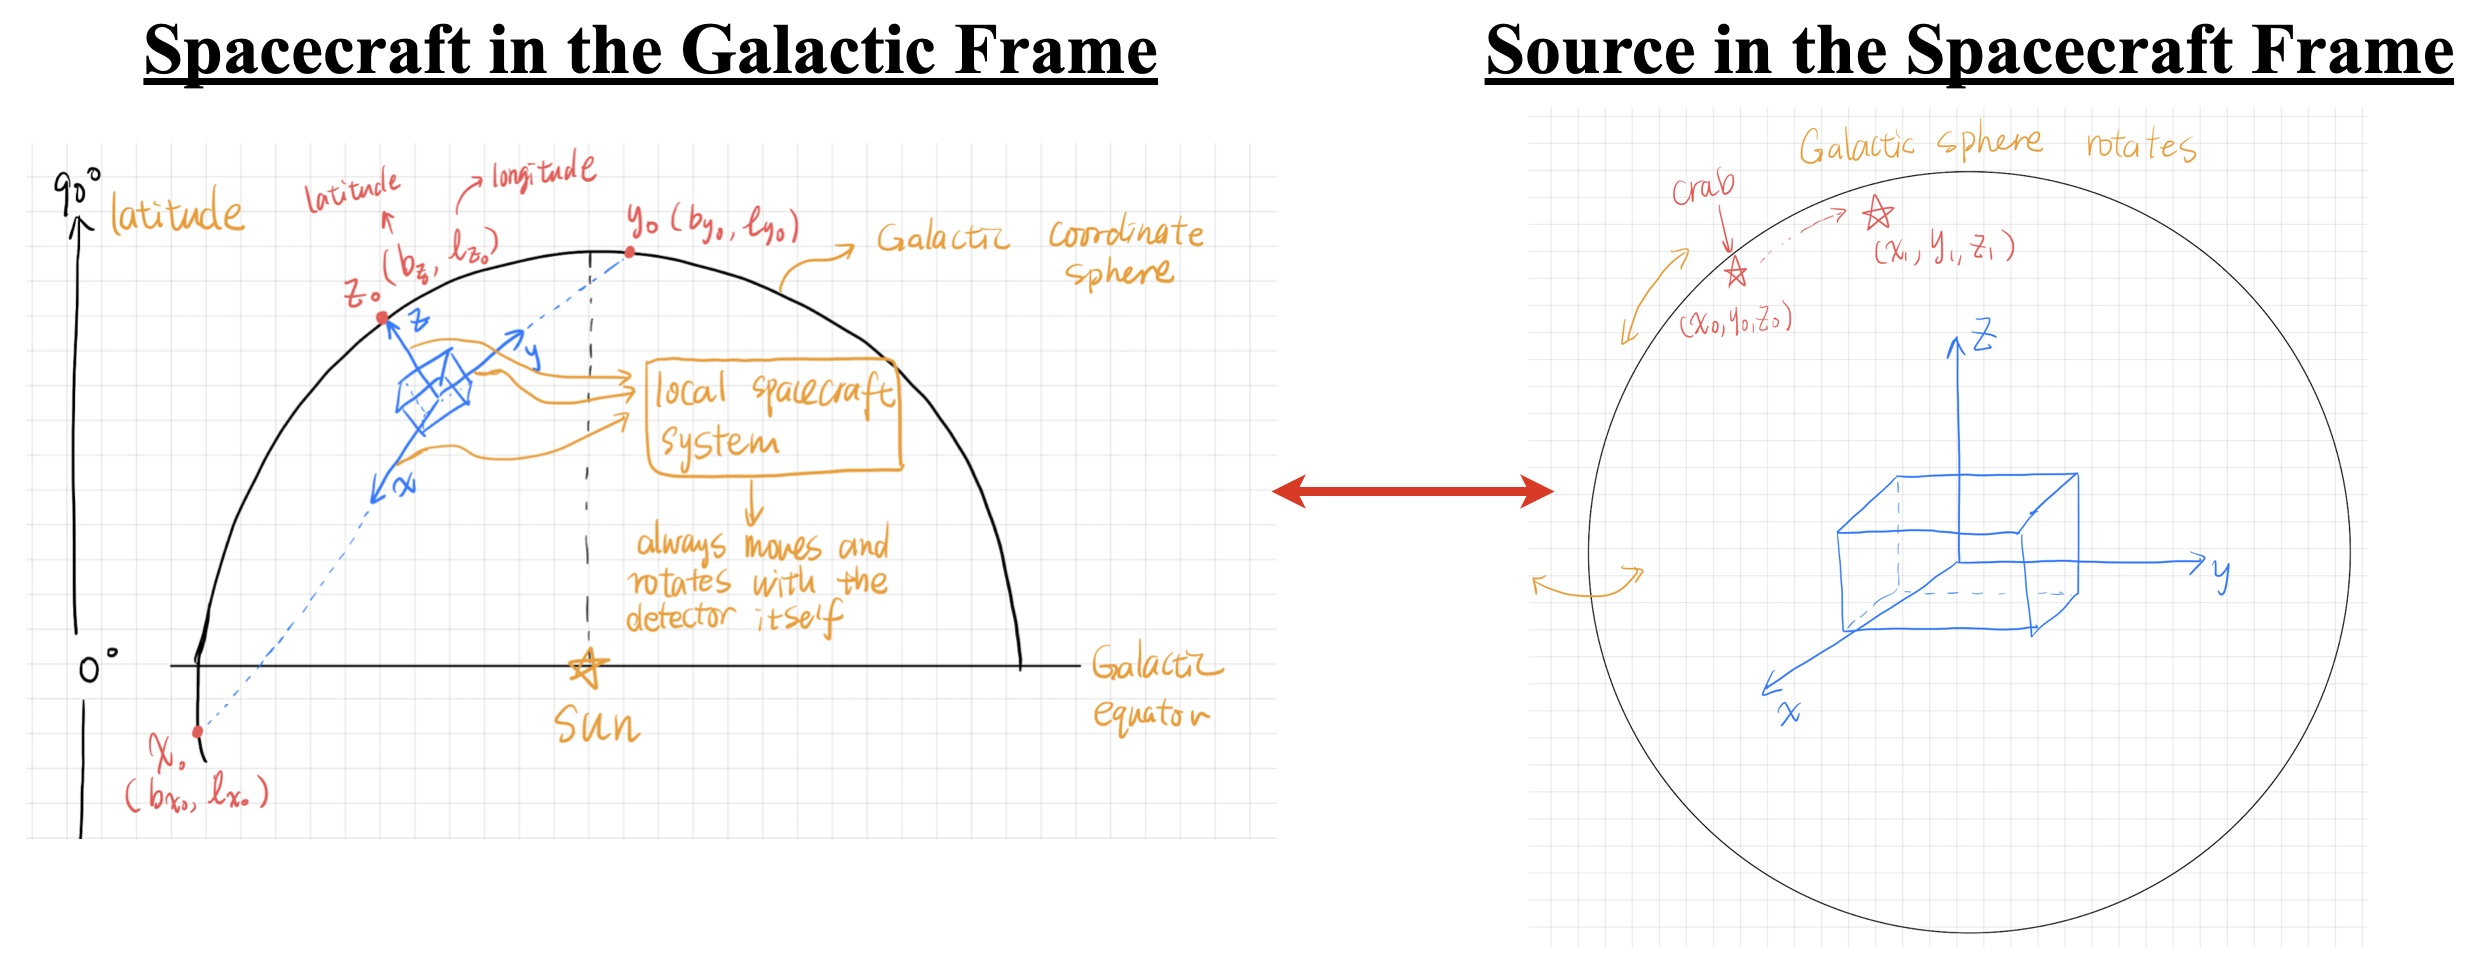

## Dependencies

This notebook requires the new cosipy installed. The public review version works.

The module that handles the the coordinate frame conversion, dwell map, and point response is called `SpacecrafPositionAttitude`

More file reading with different types (fits, tra and ori) will be supported in the future. Now it only reads the coordinates in numpy array.

In [12]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from mhealpy import HealpixMap
import matplotlib.pyplot as ply
import pandas as pd
from astropy.time import Time
from pathlib import Path

from scoords import Attitude
from cosipy.response import FullDetectorResponse
from scoords import SpacecraftFrame
from cosipy.coordinates.orientation import Orientation_file
from cosipy.spacecraftfile import SpacecraftFile

14:00:25 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=553620;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=75669;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=557713;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=158573;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

/home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=500568;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=988985;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#36\36]8;;\
                  available                                                                                        

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=391657;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=463620;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=697023;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=81565;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=978305;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=258806;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=621680;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=841863;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of F to 1e-99 because there was a postive transform   ]8;id=223138;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=663552;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=313596;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=149366;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

/home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


14:00:25 INFO      Starting 3ML!                                                                     ]8;id=744825;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=479321;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=690114;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=784608;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=158212;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=940903;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=766350;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=850378;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   ROOT minimizer not available                                                ]8;id=838694;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=499712;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=210924;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=292046;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=428170;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=938160;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

         WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=916193;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=102124;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=421907;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=877959;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=977022;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=212222;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   No fermitools installed                                              ]8;id=223472;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=742118;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=865520;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=937842;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=656487;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=617168;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=57542;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=214852;file:///home/yong/anaconda3/envs/cosipy_spaceccraftfile/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

## Load the x, y and z pointings

In [16]:
# Load the orientation from a orientation file
# Note that the reading of the balloon orientation file might 
# flip the longitude and latitude columns
ori = Orientation_file.parse_from_file("/home/yong/Desktop/AllData.ori")

In [17]:
# Load the extracted x, y, z pointings and timestamp from saved numpy files
pointing_data_path = Path("Pointings")

time = np.load(pointing_data_path / "Cygx1_balloon_timestamp_random_remove_none.npy")
xpointings = np.load(pointing_data_path / "Cygx1_balloon_xpoins_remove_none.npy")
ypointings = np.load(pointing_data_path / "Cygx1_balloon_ypoins_remove_none.npy")
zpointings = np.load(pointing_data_path / "Cygx1_balloon_zpoins_remove_none.npy")

ori = SpacecraftFile(time, xpointings, ypointings, zpointings)

Text(0, 0.5, 'Latitude [deg]')

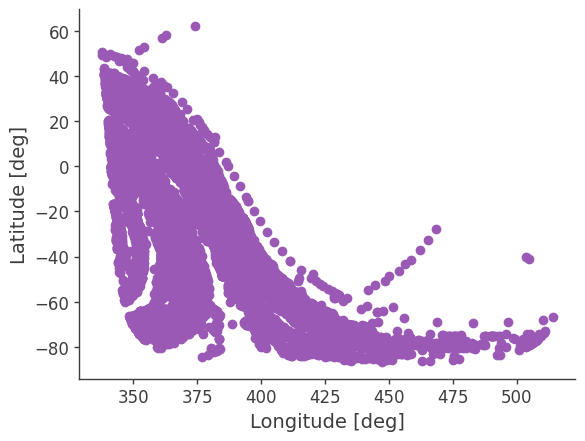

In [18]:
# you can plot the pointings to see how the zenith changes over the observation
plt.plot(ori._z_direction[:,0]+360, ori._z_direction[:,1],"o")
plt.xlabel("Longitude [deg]")
plt.ylabel("Latitude [deg]")

## Calculate the source movement in the SC frame

In [6]:
# define the target coordinates
target_coord = SkyCoord(71.334998265514, 03.0668346317, unit = "deg", frame = "galactic")

# get the target path in the Spacecraft frame 
target_in_sc_frame = ori.get_target_in_sc_frame(target_name = "CygX1", target_coord = target_coord)

Now converting to the Spacecraft frame...
Conversion completed!


In [7]:
x,y,z = ori.get_attitude().as_axes()

In [8]:
print(x)

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, )
    [(268.1196981 , -56.50178207, 1.), (265.3841073 , -52.23146918, 1.),
     (263.49578225, -47.72466869, 1.), ...,
     (197.76699436,   0.99461031, 1.), (198.42999854,   5.5610624 , 1.),
     (200.65899678,   6.15667352, 1.)]>


Text(0, 0.5, 'Latotiude [deg]')

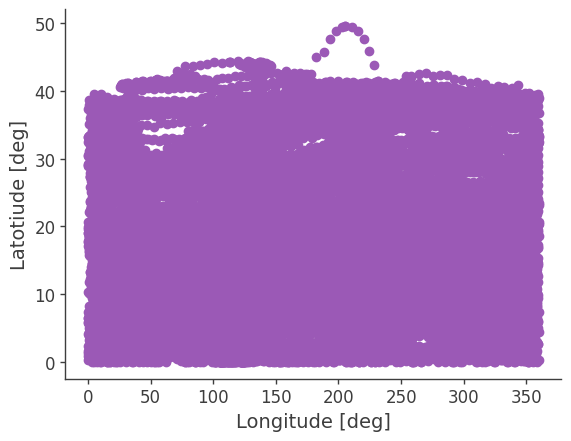

In [9]:
plt.plot(target_in_sc_frame.lon.deg, target_in_sc_frame.lat.deg,"o")
plt.xlabel("Longitude [deg]")
plt.ylabel("Latotiude [deg]")

## Get dwell time map

In [32]:
# Here since you already generate the src movement in the pipeline above, you don't need to specify the src_path parameter.

#define the response file
response_file_dir = Path("./Response/test_full_detector_response.h5")

# use the low resolution response
dwell_time_map = ori.get_dwell_map(response = response_file_dir)

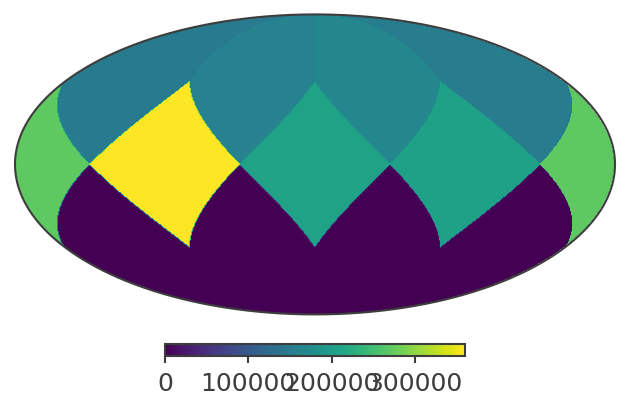

In [33]:
#Plot the dwell time map in detector coordinates (top is zenith)

_,ax = dwell_time_map.plot(coord = SpacecraftFrame(attitude = Attitude.identity()));

## Get the point source response

In [34]:
_ =  ori.get_psr_rsp()

Getting the effective area ...
Getting the energy redistribution matrix ...


In [35]:
#The idea is the same as dwell time map: if you already have the dwell time map, you don't need to run all the steps above, 
#simply load the dwell timemap here by speficifying the dwell_map parameter.

_ =  ori.get_psr_rsp(response =response_file_dir,
                     dwell_map = "CygX1_DwellMap.fits")


Getting the effective area ...
Getting the energy redistribution matrix ...


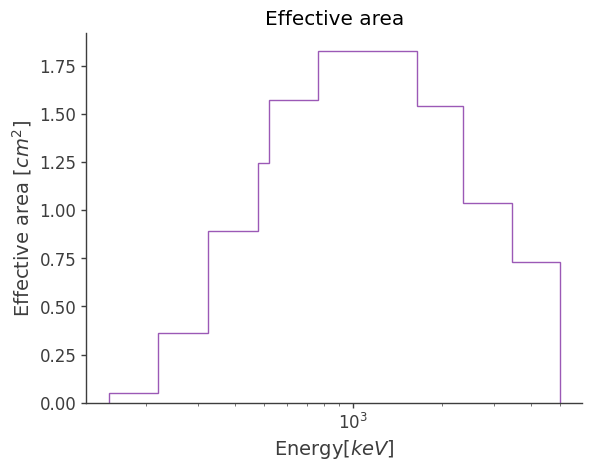

In [36]:
ori.get_arf()
ori.plot_arf()

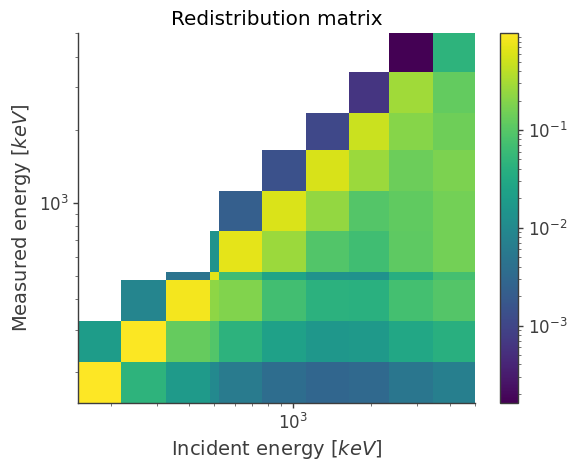

In [37]:
ori.get_rmf()
ori.plot_rmf()